# MLP

The bigram model using probablities based on normalized counts has it's limitations.

To extend it to have more context like a two characters as input the probabalities matrix will have (27*27) possilities and for three characters (27 * 27 * 27) and becomes too big.

To overcome this we're gonna try out [Bengion et al.2003 MLP model paper](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbVhPSHNrVkluYVY5elh4RDZrOWd4R2xVNVRQd3xBQ3Jtc0tsUDE0UFVRQURUTTlWckExZWp4eGxFa3lRYlQ3amtYX3kxdDI1ZW5uU1pxZERidUYyZkJjSVlzd21rMndCMFlYRW5kYmZISkxfSDR1TzhaOXI1bXptUnUxU0xyUXJYeEpTZlRrTkRjTS0wTkMxNjFnSQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I)

* This paper uses words but we'll proceed with characters
* Each character will be represented as a 30 dimensional vector 
* The advantages of embeddings is knowledge transference, for examples animals like dog, cat might be closer to each other in 30 dimensional space. If cat was not in training set but this knowledge transfer will help in this case.

Let's implement the below architecture in this notebook
![fully connected MLP](https://pbs.twimg.com/media/Fhzl42hVUAI9U8V?format=jpg&name=large)

* Three input characters with 30 dimensional embedding each
* A Lookup table for characters
* Tanh activation connected to three inputs
* since we have 27 characters a final layer with 27 units(logits)
* softmax on top of it to normalize the probabality
* pluck the label based on probabality

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Rebuilding training dataset

In [32]:
# Read all words
def read_words():
    words = open("names.txt").read().splitlines()
    return words
words = read_words()

In [33]:
len(words)

32033

In [34]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi  = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the dataset

In [35]:
def build_dataset(block_size, number_of_words: int, logs=False):
    import random
    random.seed(42)
    random.shuffle(words)
    block_size = block_size # Context ength: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words[:number_of_words]:
        if logs:
            print(w)
        context = [0] * block_size
        for ch in w + '.':
            if logs:
                print(f"Context: {context}")
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if logs:
                print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
            if logs:
                print(f"Context after append: {context}")

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [36]:
X, Y = build_dataset(block_size=3, number_of_words=5, logs=True)

yuheng
Context: [0, 0, 0]
... ---> y
Context after append: [0, 0, 25]
Context: [0, 0, 25]
..y ---> u
Context after append: [0, 25, 21]
Context: [0, 25, 21]
.yu ---> h
Context after append: [25, 21, 8]
Context: [25, 21, 8]
yuh ---> e
Context after append: [21, 8, 5]
Context: [21, 8, 5]
uhe ---> n
Context after append: [8, 5, 14]
Context: [8, 5, 14]
hen ---> g
Context after append: [5, 14, 7]
Context: [5, 14, 7]
eng ---> .
Context after append: [14, 7, 0]
diondre
Context: [0, 0, 0]
... ---> d
Context after append: [0, 0, 4]
Context: [0, 0, 4]
..d ---> i
Context after append: [0, 4, 9]
Context: [0, 4, 9]
.di ---> o
Context after append: [4, 9, 15]
Context: [4, 9, 15]
dio ---> n
Context after append: [9, 15, 14]
Context: [9, 15, 14]
ion ---> d
Context after append: [15, 14, 4]
Context: [15, 14, 4]
ond ---> r
Context after append: [14, 4, 18]
Context: [14, 4, 18]
ndr ---> e
Context after append: [4, 18, 5]
Context: [4, 18, 5]
dre ---> .
Context after append: [18, 5, 0]
xavien
Context: [0, 0

In [37]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([36, 3]), torch.int64, torch.Size([36]), torch.int64)

In [38]:
X

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        [25, 21,  8],
        [21,  8,  5],
        [ 8,  5, 14],
        [ 5, 14,  7],
        [ 0,  0,  0],
        [ 0,  0,  4],
        [ 0,  4,  9],
        [ 4,  9, 15],
        [ 9, 15, 14],
        [15, 14,  4],
        [14,  4, 18],
        [ 4, 18,  5],
        [ 0,  0,  0],
        [ 0,  0, 24],
        [ 0, 24,  1],
        [24,  1, 22],
        [ 1, 22,  9],
        [22,  9,  5],
        [ 9,  5, 14],
        [ 0,  0,  0],
        [ 0,  0, 10],
        [ 0, 10, 15],
        [10, 15, 18],
        [15, 18,  9],
        [ 0,  0,  0],
        [ 0,  0, 10],
        [ 0, 10, 21],
        [10, 21,  1],
        [21,  1, 14],
        [ 1, 14, 12],
        [14, 12, 21],
        [12, 21,  9],
        [21,  9, 19]])

In [39]:
Y

tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12, 21,  9, 19,  0])

Now we've the dataset, let's build the embedding lookup table

## Embedding lookup table

For 1700 words, 30 dimension space was used in paper. For 27 possiblities(characters) let's try a 2 dimensionsal embedding.

In [40]:
# Initialized randomnly
C = torch.randn((27, 2))
C, C.shape

(tensor([[ 0.9122, -2.6429],
         [ 1.2523,  1.5196],
         [-0.3277, -1.3908],
         [-1.5812, -0.2596],
         [-0.8151,  0.7900],
         [-0.1013,  1.0938],
         [ 1.9051, -0.4893],
         [-0.2231, -0.0781],
         [-2.1392, -0.9864],
         [-1.3120, -1.1351],
         [-1.6345, -2.0381],
         [-0.9138, -2.0658],
         [-1.8135,  1.9313],
         [-0.6188, -0.4869],
         [ 0.8778, -0.2110],
         [-0.0155, -1.4742],
         [ 0.4842,  1.6302],
         [ 0.9827,  0.8461],
         [ 0.9586,  0.2187],
         [ 0.1862,  1.5088],
         [-0.2727, -0.8020],
         [-0.4902,  0.6619],
         [ 0.5622, -0.2775],
         [ 0.2276,  1.5579],
         [ 1.7736, -0.0092],
         [ 0.3806,  0.0655],
         [ 0.5756,  0.2700]]),
 torch.Size([27, 2]))

In [41]:
# The lookup of embedding for single character can be done two ways
# 1. Indexing
C[5]

tensor([-0.1013,  1.0938])

In [42]:
# 2. Onehot
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1013,  1.0938])

Indexing and one hot encoding gives the same results. We'll use indexing as it's faster.

In [43]:
# Indexing multiple values
# Singce our shape of input is 32, 3
print(C[[5, 6, 7]])
# Works also with tensor
print(C[torch.tensor([5, 6, 7])])

tensor([[-0.1013,  1.0938],
        [ 1.9051, -0.4893],
        [-0.2231, -0.0781]])
tensor([[-0.1013,  1.0938],
        [ 1.9051, -0.4893],
        [-0.2231, -0.0781]])


In [44]:
# The total equivalent would be
C[X]

tensor([[[ 0.9122, -2.6429],
         [ 0.9122, -2.6429],
         [ 0.9122, -2.6429]],

        [[ 0.9122, -2.6429],
         [ 0.9122, -2.6429],
         [ 0.3806,  0.0655]],

        [[ 0.9122, -2.6429],
         [ 0.3806,  0.0655],
         [-0.4902,  0.6619]],

        [[ 0.3806,  0.0655],
         [-0.4902,  0.6619],
         [-2.1392, -0.9864]],

        [[-0.4902,  0.6619],
         [-2.1392, -0.9864],
         [-0.1013,  1.0938]],

        [[-2.1392, -0.9864],
         [-0.1013,  1.0938],
         [ 0.8778, -0.2110]],

        [[-0.1013,  1.0938],
         [ 0.8778, -0.2110],
         [-0.2231, -0.0781]],

        [[ 0.9122, -2.6429],
         [ 0.9122, -2.6429],
         [ 0.9122, -2.6429]],

        [[ 0.9122, -2.6429],
         [ 0.9122, -2.6429],
         [-0.8151,  0.7900]],

        [[ 0.9122, -2.6429],
         [-0.8151,  0.7900],
         [-1.3120, -1.1351]],

        [[-0.8151,  0.7900],
         [-1.3120, -1.1351],
         [-0.0155, -1.4742]],

        [[-1.3120, -1

In [45]:
# Let's verify this
C[X].shape

torch.Size([36, 3, 2])

32 is total number of inputs with shape 3 and dimensional embedding 2.

In [46]:
X[13, 2]

tensor(18)

In [47]:
C[X][13, 2]

tensor([0.9586, 0.2187])

In [48]:
C[1]

tensor([1.2523, 1.5196])

In [49]:
emb = C[X]
emb.shape

torch.Size([36, 3, 2])

Now the embedding lookup table is completed.

## Implementing the hidden layer plus internals of torch.Tensor, storage and views

In [50]:
# Intitializing weights and biases
W1 = torch.randn((
    6, # 3(inputs) * 2(embedding dim)
    100 # Number of neurons
))
b1 = torch.randn(100)

In [51]:
W1.shape

torch.Size([6, 100])

In [52]:
# # Inputs * weights + bias will not work  now
# # as dimensions of weighs and input doesn't abide
# # by matrix multiplication rulees
# # shape of input [32, 3, 2], weights [6, 100]
# emb @ W1 + b1

PyTorch's tensor's a really powerful, because ut has tons of methods to allow us to create modify and perfom lot's of operations on it.

We're gonna use [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html) to tackle the above problem.

In [53]:
cat_tensors = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
cat_tensors.shape

torch.Size([36, 6])

In [54]:
# To generalize this in case of diffrent block size
# We'll use unbind with cat
unbind_tensors = torch.unbind(emb, 1)
# Gives a list which is exactly the same
# as cat_tensors abov
len(unbind_tensors)

3

In [55]:
cat_unbind_tensors = torch.cat(unbind_tensors, 1)
cat_unbind_tensors.shape

torch.Size([36, 6])

Now irrespective of block size the above code will run.

But there's an efficient way to do this.

In [56]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [57]:
a.shape

torch.Size([18])

In [58]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [59]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

Every tensor has view and storage,
* Using tensor.view(shape) we can manipulate the shape of an tensor
* But tensor.storage() in memory will still remain a single dimension vector
* And using view just changes some attributes like offest etc and tensor in memory remains same to the multiples

In [63]:
emb.shape

torch.Size([36, 3, 2])

In [64]:
# Let's use view() to reshape the tensor from [32, 3, 2] to [32, 6]
emb.view(36, 6)

tensor([[ 0.9122, -2.6429,  0.9122, -2.6429,  0.9122, -2.6429],
        [ 0.9122, -2.6429,  0.9122, -2.6429,  0.3806,  0.0655],
        [ 0.9122, -2.6429,  0.3806,  0.0655, -0.4902,  0.6619],
        [ 0.3806,  0.0655, -0.4902,  0.6619, -2.1392, -0.9864],
        [-0.4902,  0.6619, -2.1392, -0.9864, -0.1013,  1.0938],
        [-2.1392, -0.9864, -0.1013,  1.0938,  0.8778, -0.2110],
        [-0.1013,  1.0938,  0.8778, -0.2110, -0.2231, -0.0781],
        [ 0.9122, -2.6429,  0.9122, -2.6429,  0.9122, -2.6429],
        [ 0.9122, -2.6429,  0.9122, -2.6429, -0.8151,  0.7900],
        [ 0.9122, -2.6429, -0.8151,  0.7900, -1.3120, -1.1351],
        [-0.8151,  0.7900, -1.3120, -1.1351, -0.0155, -1.4742],
        [-1.3120, -1.1351, -0.0155, -1.4742,  0.8778, -0.2110],
        [-0.0155, -1.4742,  0.8778, -0.2110, -0.8151,  0.7900],
        [ 0.8778, -0.2110, -0.8151,  0.7900,  0.9586,  0.2187],
        [-0.8151,  0.7900,  0.9586,  0.2187, -0.1013,  1.0938],
        [ 0.9122, -2.6429,  0.9122, -2.6

The way this happens is dimension 1 get stacked up as a single dimension.

In [65]:
emb.view(36, 6).shape

torch.Size([36, 6])

In [66]:
emb.view(36, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Element wise comparison proves that view is equal to cat(unbind)

In [67]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.9988,  0.9969, -0.8849,  ...,  0.9913, -0.9999, -0.9221],
        [ 0.9992, -0.9688, -0.9553,  ...,  0.9150, -0.9985, -0.6239],
        [ 0.8469, -0.9303, -0.9902,  ...,  0.9982, -0.7197,  0.9150],
        ...,
        [-0.5266, -0.1498, -0.7658,  ..., -0.9861,  0.9993, -0.8392],
        [-0.8574,  0.9922, -0.9428,  ..., -1.0000,  1.0000, -0.6005],
        [ 0.9185, -0.9999,  0.3922,  ..., -1.0000,  0.9569, -0.9943]])

In [68]:
h.shape

torch.Size([36, 100])

Make sure broadcasting is done right

In [70]:
(emb.view(36, 6) @ W1).shape

torch.Size([36, 100])

In [ ]:
b1.shape

torch.Size([100])

32, 100
1 , 100

* broadcasting 32, 100 to 100
* broadcasting aligns from right abd creates a  fake dimension (1)
* Then 32 will be copied vertically for every element of 100

## Implementing output layer

In [ ]:
W2 = torch.randn((100, # Inputs layer size
                  27 # Output layer 27 characters
                 ))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

## Implmenting negative log likelihood loss

In [ ]:
# Fake counts -> logits exp
counts = logits.exp()

In [ ]:
# Normalize fake counts
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [ ]:
Y.shape

torch.Size([32])

In [ ]:
# Indexing probabalites based on Y
# This probabalities in future will be the probabalities by neural network
prob[torch.arange(32), Y]

tensor([2.0302e-12, 3.0087e-11, 2.2926e-04, 4.6576e-08, 4.9097e-10, 7.6412e-07,
        6.5631e-08, 1.0698e-06, 2.2241e-01, 4.2247e-08, 2.2134e-02, 2.9667e-02,
        9.0340e-06, 1.9233e-02, 8.2616e-04, 4.3171e-10, 1.9756e-05, 4.2781e-12,
        3.9354e-01, 8.5710e-11, 1.7523e-01, 3.2123e-13, 4.5706e-08, 9.0118e-07,
        2.4984e-08, 1.5934e-06, 4.8878e-01, 1.4339e-08, 2.4175e-05, 2.0196e-11,
        8.6646e-01, 5.8889e-14])

In [ ]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(14.0688)

## Summary of full network

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
paramerters = [C, W1, b1, W2, b2]

In [ ]:
# Number of parameters in total
sum(p.nelement() for p in paramerters)

3481

In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

## Cross entropy why?

```
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = - prob[torch.arange(32), Y].log().mean()
```

PyTorch creates a seperate tensor for each of these step

1. Uses a fused kernel which combines all the above operations
2. In backward pass, expression takes much simpler form mathametically
3. Under the hood, this is numerically well behaved
4. Forward pass and backward pass are much more efficient

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [ ]:
# Numerical stability difference
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [ ]:
# Numerical stability difference
# With more extreme values, which will occur in backpropgation
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
print(f"Counts: {counts}")
probs = counts / counts.sum()
probs

Counts: tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])


tensor([0., 0., 0., nan])

What's happening above is the floating point ran out of dynamic range for exp(100) returning inf
and for negative 100 the probs is near zero.

So we cannot pass very larger number to our logits --> loss expression

In [ ]:
# How PyTorch handles this is
# By finding maximum of the logits and offsets it from the logits to avoid it
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
print(f"Counts: {counts}")
probs = counts / counts.sum()
probs

Counts: tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])


tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

## Implementing training loop, overfitting one batch

In [ ]:
# Set requires grad
for p in paramerters:
    p.requires_grad = True
for _ in range(1000):
    # Forward pass
    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)
    loss = F.cross_entropy(logits, Y)
    # Backward pass
    for p in paramerters:
        p.grad = None
    loss.backward()
    
    # Update parametrs
    for p in paramerters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2561391294002533


We've achieved a very good loss. Why?
Because we're fitting the model for only 5 words i.e 32 inputs and with 3481 parameters.
Lots of paramters for very less data.
What we're doing it overfitting the model for one batch of data.

> Note: Based on this overfitting can be defined as tuning many parameters for few samples or a batch of data.

Why loss of 0 is not achieved?

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7904, 20.6014, 20.6121, 16.7355, 13.3348, 15.9983, 14.1722,
        15.9145, 18.3614, 15.9395, 20.9265, 13.3348, 17.1090, 17.1319, 20.0602,
        13.3348, 16.5893, 15.1017, 17.0581, 18.5860, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1795, 16.9743, 12.7426, 16.2009, 19.0845, 16.0196],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

We can see the indices of logits and output are same for most of the cases, these are inputs overfitted to outputs. But the missing ones are 

* ... --> e (emma)
* ... --> o (olivia)
* ... --> a (ava)
* ... --> s (sophia)

for different outptus for the same input.

To overcome this, let's train on the full dataset.

## Training on full dataset, minibatches

In [ ]:
X, Y = build_dataset(block_size=3, number_of_words=len(words),logs=False)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(10):
    
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
19.505226135253906
17.084495544433594
15.013856887817383
13.038172721862793
11.437594413757324
10.590070724487305
9.906834602355957
9.059294700622559
8.551025390625
8.10305118560791
Final loss: 8.10305118560791


Each epoch is taking more time, becuase forwarding and backwarding for 228146 samples compared to 32 samples.
We can overcome this by training on minibatches instead of training on entire dataset

In [ ]:
# Mini batch size of 32
# from 0 to number of samples which is X.shape[0]
# This willl index 32 random samples in X
torch.randint(0, X.shape[0], (32,))

tensor([133389, 170367, 171642, 185281, 122222,  97551,    246, 213195,  48626,
        131523, 132314, 136782,  87017, 221884, 136272, 158338,  24075,  84146,
        148179,  12556,  49282, 206798, 170648, 116141, 203928, 152969, 176780,
         71657,  46643, 102359, 119842,   6829])

In [ ]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(100):

    # mini batch indexes
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
18.95673370361328
17.42254638671875
12.630152702331543
13.045025825500488
9.12990951538086
10.035116195678711
8.557498931884766
11.08382511138916
9.528258323669434
8.964183807373047
10.115828514099121
9.677383422851562
11.079150199890137
9.796181678771973
9.937837600708008
9.526925086975098
10.806981086730957
9.747477531433105
11.103167533874512
14.12124252319336
9.104704856872559
14.226822853088379
11.040562629699707
12.05095100402832
13.552815437316895
10.876388549804688
12.439581871032715
10.587907791137695
13.555068969726562
9.734114646911621
11.511343002319336
8.97689437866211
10.525503158569336
10.96102237701416
10.543774604797363
11.637333869934082
13.332690238952637
10.781798362731934
10.427427291870117
10.113097190856934
10.02184772491455
9.452690124511719
12.526015281677246
8.948640823364258
10.771397590637207
11.478919982910156
8.886293411254883
12.030909538269043
11.14488697052002
12.509180068969727
11.619462013244629
10.044418334960938
13.00309371948

Adavantages with mini batching:

* Faster training cycle
* Random indexing leads to differnt data for each mini batch

> Since model's trained on mini batches, the quality of gradient is lower and is not reliable. It's not the actual gradient direction. But the gradient direction is good enough even when estimated on a mini batch(32 samples) to be useful.
It's much better to have a approximate gradient direction and more steps than an exact or actual gradient with much fewer steps.
That's why this works in practice.

In [ ]:
# Evaluation loss for entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(17.1861, grad_fn=<NllLossBackward0>)

## Finding a good learning rate

To find a good learnning rate...

We need to find a good lower limt and an upper limit where loss is improving.

In [ ]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(100):

    # mini batch indexes
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
20.148361206054688
15.050707817077637
18.712387084960938
20.79283905029297
16.606122970581055
14.798345565795898
23.448040008544922
26.29581642150879
18.202688217163086
29.81456184387207
25.67377281188965
26.829753875732422
28.772035598754883
44.843162536621094
45.72543716430664
48.91575622558594
47.13222885131836
45.722450256347656
53.842079162597656
51.96746063232422
39.033870697021484
45.76651382446289
42.57117462158203
43.8768196105957
40.501346588134766
37.41219711303711
52.57552719116211
60.38792037963867
53.53440475463867
59.46855545043945
56.20912170410156
68.50389099121094
65.18240356445312
60.44708251953125
64.49718475341797
66.65176391601562
62.1620979309082
58.81123733520508
51.62526321411133
62.23068618774414
63.7938346862793
68.99462890625
97.50465393066406
77.49337005615234
96.84265899658203
102.60186004638672
110.24796295166016
105.42243957519531
95.50444030761719
73.69699096679688
84.7665786743164
117.14938354492188
110.01004791259766
62.21091842

After trying out different learning rates from -0.0001 and -10.. Good lower limit and upper limit are -0.01 and -1 respectivley.
With these learning rates the convergence is not really slow or exploding.

In [ ]:
lre = torch.linspace(
    -3, # 10**2-3 = 0.01
    0, # 10**0 = 1
    1000 # 1000 learning rates from upper limit and lower limit exponentially stepped
)
lrs = 10**lre

In [ ]:
# Finding the ideal learning rate
# Parameters
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parametrs: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# Metrics
lri = []
lossi = []
for i in range(1000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = lrs[i]
    for p in parameters:
        p.data += - lr * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())
print(f"Final loss: {loss.item()}")

Total parametrs: 3481
13.98857307434082
13.427151679992676
12.359247207641602
14.027222633361816
13.295552253723145
13.379878044128418
13.199939727783203
13.153809547424316
10.42131233215332
9.028179168701172
13.993346214294434
12.002320289611816
12.500282287597656
13.362969398498535
13.290543556213379
13.114940643310547
12.48984432220459
13.29937744140625
14.543453216552734
11.367942810058594
14.493165016174316
12.865060806274414
12.219062805175781
14.321101188659668
13.913798332214355
14.795360565185547
13.251361846923828
11.954629898071289
14.85689640045166
11.425674438476562
14.298286437988281
12.596880912780762
12.68897533416748
12.303581237792969
12.209415435791016
13.273768424987793
11.619229316711426
12.523968696594238
10.579257011413574
11.485825538635254
11.944574356079102
13.416412353515625
13.872958183288574
12.709575653076172
12.126797676086426
13.867707252502441
15.350515365600586
15.066499710083008
12.38978385925293
12.698241233825684
11.416839599609375
14.17424392700195

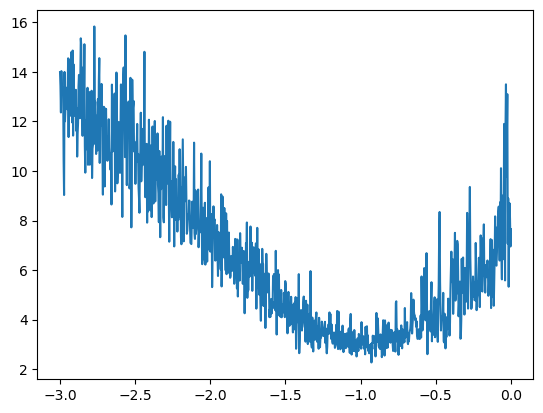

In [ ]:
plt.plot(lri, lossi)

Base on the plot, loss is less before exploding is exponent of -1.0 which is 0.1 which was our initial learning rate.
Now we can be certain that the learning rate is good.
Let's set lr to 0.1 and train for a longer period.

In [ ]:
# Parameters
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parametrs: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Total parametrs: 3481


In [ ]:
# Good learning rate from metrics
for i in range(10000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = 0.1
    for p in parameters:
        p.data += - lr * p.grad


print(f"Final loss: {loss.item()}")

Final loss: 2.6249172687530518


In [ ]:
# Evaluation loss for entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4645, grad_fn=<NllLossBackward0>)

After running traing for more than 10000 steps multiple times, we've overcome the loss of bigram model.
Now we've arrived at a point where we are near the minima. Let's do a decay of learning rate to slowly reach there.

And train.

In [ ]:
# Learning rate Decay
for i in range(10000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = 0.01
    for p in parameters:
        p.data += - lr * p.grad


print(f"Final loss: {loss.item()}")

Final loss: 1.9187628030776978


### Summary

* Find a good leaarning rate between lower and upper limit
* Train on the ideal learning rate and check for improvement in loss
* Verify that and do a learning rate decay by a small factor and train again
* Validate loss again on entitre dataset

## Splitting up the staset into train/val/test and why?

We said the loss above is lesser than the bigram model it is, but this might not be true in all cases.
Because right now we've only 3481 parameters, as the model scales up number of parameters can go up to millions and more.
At this point model will start overfitting for the data in parameters and will be able to identify only those and unseen data will fail terribly.

To avoid this, we create three splits of data from entire dataset,

1. train - to tune the parameters itself
2. val/dev - to tune hyperparameters. Like number of hidden units, loss, learning rate etc.
3. test - to validate the model on unseen data.

And test should not be used very frequently as it will lead taking the inputs or feedback from that and incorprating into training set.
We should use test set very less number of times.

In [ ]:
def build_dataset_v1(words, block_size, logs=False):
    block_size = block_size # Context ength: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        if logs:
            print(w)
        context = [0] * block_size
        for ch in w + '.':
            if logs:
                print(f"Context: {context}")
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if logs:
                print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
            if logs:
                print(f"Context after append: {context}")


    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset_v1(words=words[:n1], block_size=3)
Xdev, Ydev = build_dataset_v1(words=words[n1:n2], block_size=3)
Xte, Yte = build_dataset_v1(words=words[n2:], block_size=3)

torch.Size([182400, 3]) torch.Size([182400])
torch.Size([22962, 3]) torch.Size([22962])
torch.Size([22784, 3]) torch.Size([22784])


In [ ]:
# Train dataset
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
# Resetting network
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum (p.nelement() for p in parameters)

3481

In [ ]:
Xtr.shape[0]

182400

In [ ]:
for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lrs = []

In [ ]:
for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad


In [ ]:
print(loss.item())

2.457670211791992


In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.4775
# 2. steps = 30000, batch = 32, lr = 0.1, loss = 2.4265
# 2. steps = 30000, batch = 32, lr = 0.01, loss = 2.3213

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3213, grad_fn=<NllLossBackward0>)

In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.4830
# 2. steps = 10000, batch = 32, lr = 0.1, loss = 2.4347
# 2. steps = 30000, batch = 32, lr = 0.01, loss = 2.3276

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3276, grad_fn=<NllLossBackward0>)

The training loss and test loss difference is not huge, so we're not overfitting but it's nearly equal. This is underfitting, we don't have a big network to overfit the data. Let's try that next.

## Experiment: Large Hidden layer

100 --> 300 units

In [ ]:
# Resetting network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

10281


In [ ]:
# 1. Try more steps, as network size is increased
# 2. Try different batch sizes, since too small a batch size might return a bad thrashing gradient

In [ ]:
# Stats
lossi = []
stepi = []

for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # Forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())

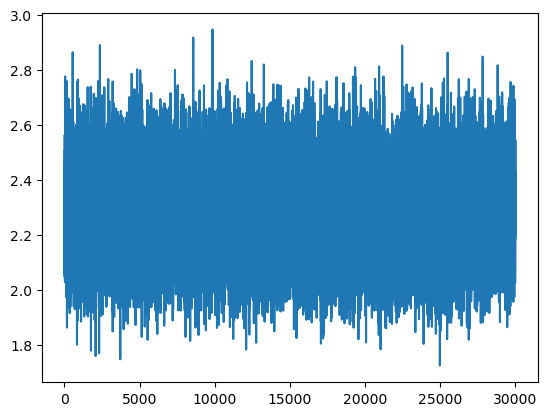

In [ ]:
plt.plot(stepi, lossi);

In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.6616
# 2. steps = 30000, batch = 64, lr = 0.1, loss = 2.3609
# 2. steps = 30000, batch = 64, lr = 0.01, loss = 2.2780

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2780, grad_fn=<NllLossBackward0>)

In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.6711
# 2. steps = 30000, batch = 64, lr = 0.1, loss = 2.3696
# 2. steps = 30000, batch = 64, lr = 0.01, loss = 2.2898

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2898, grad_fn=<NllLossBackward0>)

The dev loss is not decreasing much, even though we've increased number of model parameters.

2.3286 (3481 parameters) --> 2.2898(10281 parameters)

We've increased the number of units in tanh layer.
The bottleneck of the network performance might be the two dimensional embeding layer is not enough. 
We're scramming way too many characters into embeddings and not able to use that effectivley.

One thing before we scale up the embeddings from two dimensions is to visualize them. Once we go beyond two dimensions, we can't visualize the embeddings.

## Visualizing the character embeddings

In [ ]:
C.shape

torch.Size([27, 2])

In [ ]:
C.shape[0]

27

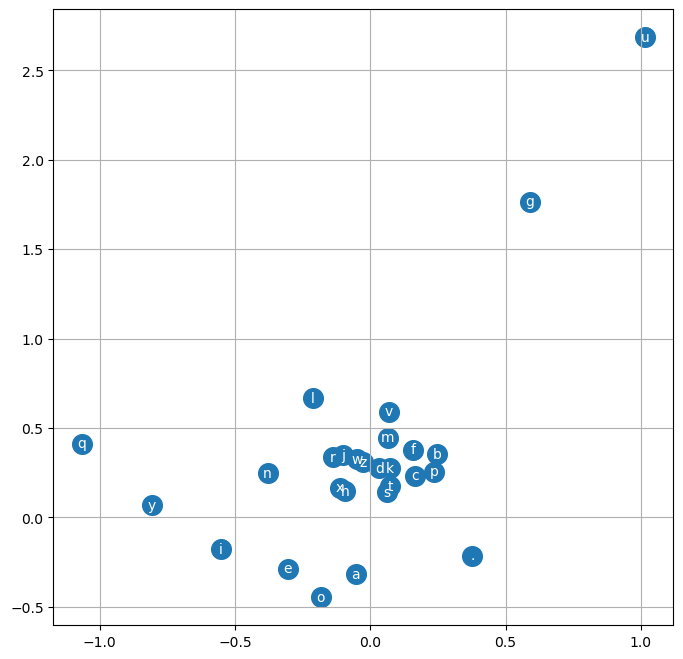

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

## Increasing embedding dimension

In [ ]:
# Resetting network
# Incresing embedding dimension 2 --> 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [ ]:
# Stats
lossi = []
stepi = []

In [ ]:
for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

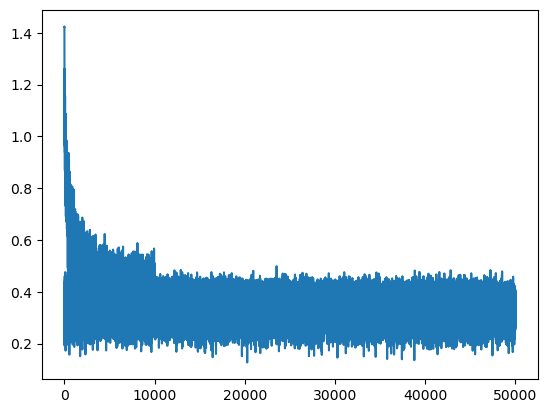

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.5751
# 2. steps = 50000, batch = 64, lr = 0.1, loss = 2.2206
# 3. steps = 50000, batch = 64, lr = 0.01, loss = 2.1150
# 4. steps = 50000, batch = 32, lr = 0.01, loss = 2.1150

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1150, grad_fn=<NllLossBackward0>)

In [ ]:
# 1. steps = 10000, batch = 32, lr = 0.1, loss = 2.6035
# 2. steps = 50000, batch = 64, lr = 0.1, loss = 2.2707
# 3. steps = 50000, batch = 64, lr = 0.01, loss = 2.1655
# 4. steps = 50000, batch = 32, lr = 0.01, loss = 2.1150

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1655, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1785, grad_fn=<NllLossBackward0>)

> Note: So use the paramters where dev loss is good and use that to train the network. Use this network to evaluate the loss on test set once.

## Sampling from the model

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view)